In [1]:
# xlrd==1.2.0

In [1]:
import os
import re
import math
import pandas as pd
import empyrical as empy
from dateutil.relativedelta import relativedelta

from datetime import date, datetime
warnings.filterwarnings("ignore")

In [2]:
def get_sim_record(fn):
    files = os.listdir(fn)
    df = pd.DataFrame()
    for file in files:
        file_path = os.path.join(fn, file)
        print(file_path)
        try:
            excel_info = pd.read_excel(file_path, sheet_name=['KPI(Daily)', 'Deck Info'], index_col=0)
        except Exception as e:
            print(e)
            continue
        name = excel_info['Deck Info'].loc['full name', :].values[0]
        
        daily_return = excel_info['KPI(Daily)']       
        daily_return = daily_return['Daily Return']
        daily_return.index = pd.to_datetime(daily_return.index)
        daily_return.name = name
        df = pd.concat([df, daily_return], axis=1)
    return df


# def get_sim_record(fn):
#     short_name_map = {
#         'agg': 'AML Growth',
#         'Mod': 'AML Moderate',
#         'Con': 'AML Conservative',
#         'ficon': 'AML Conservative(Fully-invested)',
#         '6e4b': '60 Equities & 40 Bonds',
#         'spy': 'SPY'
#     }
#     files = os.listdir(fn)
#     df = pd.DataFrame()
#     for file in files:
#         file_path = os.path.join(fn, file)
# #         print(file_path)
#         try:
#             daily_return = pd.read_csv(file_path, index_col=0, header=None)
#             daily_return = daily_return.fillna(0.0)
#         except:
#             continue
#         name = short_name_map[file.split("_")[1]]
# #         print(name)
#         daily_return.index = pd.to_datetime(daily_return.index)
#         daily_return.columns = [name]
#         df = pd.concat([df, daily_return], axis=1)
            
#     return df

In [3]:
def get_ib_record(fn, account_map):
    files = os.listdir(fn)
    ret = pd.DataFrame()
    allocate_dict = {}
    for file in files:
        found = False
        for name in account_map.keys():
            for account in account_map[name]:
                if account in file:
                    found = True
                    break
                else:
                    continue
            if found:
                break
        print("file: ", file, " name: ", name, " account: ", account)
        
        if found:
            file_path = os.path.join(fn, file)
            df = pd.read_csv(file_path, index_col=0, header=None)
            
            daily_return = reformat_daily_return(df)
            daily_return.columns = [name]
            ret = pd.concat([ret, daily_return], axis=1)
            
            allocation = reformat_allocate(df)
            allocate_dict[name] = allocation
    return ret, allocate_dict


def reformat_daily_return(df):
    info_type='Time Period Performance Statistics'
    use_col=['Date', 'Return']

    df = df.loc[info_type, :].dropna(axis=1, how='all')
    df = df.rename(columns=df.iloc[1])
    df = df.reset_index(drop=True)
    df = df.iloc[2:, :]
    df = df[use_col]
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index, format='%m/%d/%y')
    df = df.astype(float) / 100
    return df

def reformat_allocate(df):
    info_type='Allocation by Asset Class'
    use_col=['Date', 'Commodities', 'Equities', 'Fixed Income', 'Real Estate', 'Cash', 'NAV']
    df = df.loc[info_type, :].dropna(axis=1, how='all')
    df = df.rename(columns=df.iloc[1])
    df = df.reset_index(drop=True)
    df = df.iloc[2:, :]
    df = df[use_col]
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    return df

In [4]:
def join_sim_ib(sim_df, ib_df, sim_cutoff=None):
    """
    sim_cutoff is None, use full real record
    """
    joined_df = pd.DataFrame()
    for col in sim_df:
        if col in ib_df.columns:
            sim_part = sim_df[col]
            ib_part = ib_df[col].dropna()
            tmp_ib_part = ib_part[ib_part != 0]
            
            if sim_cutoff is None:
                sim_cutoff = tmp_ib_part.index[0]

            join_sim = sim_part[sim_part.index < sim_cutoff]
            join_ib = ib_part[ib_part.index >= sim_cutoff]
            print("join_sim: ", join_sim.index[-1])
            print("join_ib: ", join_ib.index[0])

            joined_part = pd.concat([join_sim, join_ib])
            joined_df[col] = joined_part
        else:
            joined_df[col] = sim_df[col]
    return joined_df

In [5]:
def parse_freq(s, default_num=1):
    """Split frequency

    Args:
        s (str): rebalance frequence (e.g. 2M, 10D)
        default_num (int, optional): number of period

    Returns:
        num (int): number of period
        p (str): frequency period

    Raises:
        KeyError: Wrong input format of Frequency
    """
    r = re.compile('(|\d+)([A-Za-z]+)')
    match = r.match(s)
    if not match:
        raise KeyError('Invalid format of Frequency [{}]'.format(s))
    num, p = match.groups()
    num = int(num) if len(num) > 0 else default_num
    return num, p

In [6]:
def lookback_metrics_annul(df, lookback_period, cutoff_date=None):
    if cutoff_date is not None:
        df = df.loc[df.index < datetime.strptime(cutoff_date, '%Y-%m-%d')]
    last_date = df.index[-1]
    
    if lookback_period == 'YTD':
        sub_df = df[str(last_date.year)]
    elif lookback_period == 'INCEPTION':
        sub_df = df
    else:
        lookback, freq = parse_freq(lookback_period)
        if freq == 'Y':
            start_date = last_date - relativedelta(years=lookback) + relativedelta(months=1)
            start_str = '{}-{}'.format(start_date.year, start_date.month)
        elif freq == 'M':
            start_date = last_date - relativedelta(months=(lookback-1))
            start_str = '{}-{}'.format(start_date.year, start_date.month)
        elif freq == 'D':
            start_date = last_date - relativedelta(days=lookback)
#         print("last_date: ", last_date, " start_date: ", start_date)
        sub_df = df[start_str:]
    print("lookback_period: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])
    
    res = pd.DataFrame(columns=sub_df.columns)
    for col in sub_df.columns:
        res.loc['{} RETURN'.format(lookback_period), col] = empy.annual_return(sub_df[col])
        res.loc['{} Volatility'.format(lookback_period), col] = empy.annual_volatility(sub_df[col])
        res.loc['{} SHARPE RATIO'.format(lookback_period), col] = empy.sharpe_ratio(sub_df[col])
        res.loc['{} Max-DD'.format(lookback_period), col] = empy.max_drawdown(sub_df[col])
        res.loc['{} STD'.format(lookback_period), col] = sub_df[col].std()
        res.loc['{} Total Return'.format(lookback_period), col] = empy.cum_returns(sub_df[col]).values[-1]
        res.loc['{} worst return'.format(lookback_period), col] = min(sub_df[col])
    return res

def lookback_metrics_annul_monthly(df, lookback_period, cutoff_date=None):
    if cutoff_date is not None:
        cutoff_date = datetime.strptime(cutoff_date, '%Y-%m-%d')
        df = df.loc[:(cutoff_date.year, cutoff_date.month), ]
    last_date = date(df.index[-1][0], df.index[-1][1], 1)
    
    if lookback_period == 'YTD':
        sub_df = df.loc[last_date.year]
    elif lookback_period == 'INCEPTION':
        sub_df = df
    else:
        lookback, freq = parse_freq(lookback_period)
        if freq == 'Y':
            start_date = last_date - relativedelta(years=lookback) + relativedelta(months=1)
        elif freq == 'M':
            start_date = last_date - relativedelta(months=(lookback-1))
        elif freq == 'D':
            start_date = last_date - relativedelta(days=lookback)
        sub_df = df.loc[(start_date.year, start_date.month):, ]
    print("lookback_period: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])
    
    res = pd.DataFrame(columns=sub_df.columns)
    for col in sub_df.columns:
        res.loc['{} RETURN'.format(lookback_period), col] = empy.annual_return(sub_df[col], period='monthly')
        res.loc['{} Volatility'.format(lookback_period), col] = empy.annual_volatility(sub_df[col], period='monthly')
        res.loc['{} SHARPE RATIO'.format(lookback_period), col] = empy.sharpe_ratio(sub_df[col], period='monthly')
        res.loc['{} Max-DD'.format(lookback_period), col] = empy.max_drawdown(sub_df[col])
        res.loc['{} STD'.format(lookback_period), col] = sub_df[col].std()
        res.loc['{} Total Return'.format(lookback_period), col] = empy.cum_returns(sub_df[col]).values[-1]
        res.loc['{} worst return'.format(lookback_period), col] = min(sub_df[col])
    return res

In [7]:
def lookback_A2ACompare(df, lookback_period, benchmark_col, cutoff_date=None):
    if cutoff_date is not None:
        df = df.loc[df.index < datetime.strptime(cutoff_date, '%Y-%m-%d')]
    last_date = df.index[-1]
    
    cols = list(df.columns)
    for b in benchmark_col:
        if b in cols:
            cols.remove(b)
        else:
            print("Missing benchmark column: {}".format(b))
    benchmark_df = df[benchmark_col]
    df = df[cols]
    
    res = pd.DataFrame()
    for col in df.columns:
        subdf = df[[col]].dropna()
        if lookback_period == 'YTD':
            sub_df = subdf[str(last_date.year)]
        elif lookback_period == 'INCEPTION':
            sub_df = subdf
        else:
            lookback, freq = parse_freq(lookback_period)
            if freq == 'Y':
                start_date = last_date - relativedelta(years=lookback) + relativedelta(months=1)
                start_str = '{}-{}'.format(start_date.year, start_date.month)
            elif freq == 'M':
                start_date = last_date - relativedelta(months=(lookback-1))
                start_str = '{}-{}'.format(start_date.year, start_date.month)
            elif freq == 'D':
                start_date = last_date - relativedelta(days=lookback)
            sub_df = subdf[start_str:]
        print("lookback_period: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])

        sub_df = pd.concat([benchmark_df, sub_df], axis=1)
        sub_df = sub_df.dropna()
        print("lookback_period with benchmark: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])
        
        sub_res = pd.DataFrame(columns=sub_df.columns)
        for c in sub_df.columns:
            sub_res.loc['{} RETURN'.format(lookback_period), c] = empy.annual_return(sub_df[c])
            sub_res.loc['{} Volatility'.format(lookback_period), c] = empy.annual_volatility(sub_df[c])
            sub_res.loc['{} SHARPE RATIO'.format(lookback_period), c] = empy.sharpe_ratio(sub_df[c])
            sub_res.loc['{} Max-DD'.format(lookback_period), c] = empy.max_drawdown(sub_df[c])
            sub_res.loc['{} STD'.format(lookback_period), c] = sub_df[c].std()
            sub_res.loc['{} Total Return'.format(lookback_period), c] = empy.cum_returns(sub_df[c]).values[-1]
            sub_res.loc['{} worst return'.format(lookback_period), c] = min(sub_df[c])
        res = pd.concat([res, sub_res], axis=1)
        
    return res

def lookback_A2ACompare_monthly(df, lookback_period, benchmark_col, cutoff_date=None):
    if cutoff_date is not None:
        cutoff_date = datetime.strptime(cutoff_date, '%Y-%m-%d')
        df = df.loc[:(cutoff_date.year, cutoff_date.month), ]
    last_date = date(df.index[-1][0], df.index[-1][1], 1)
    
    cols = list(df.columns)
    for b in benchmark_col:
        if b in cols:
            cols.remove(b)
        else:
            print("Missing benchmark column: {}".format(b))
    benchmark_df = df[benchmark_col]
    df = df[cols]
    
    res = pd.DataFrame()
    for col in df.columns:
        subdf = df[[col]].dropna()
        if lookback_period == 'YTD':
            sub_df = subdf.loc[last_date.year]
        elif lookback_period == 'INCEPTION':
            sub_df = subdf
        else:
            lookback, freq = parse_freq(lookback_period)
            if freq == 'Y':
                start_date = last_date - relativedelta(years=lookback) + relativedelta(months=1)
                start_str = '{}-{}'.format(start_date.year, start_date.month)
            elif freq == 'M':
                start_date = last_date - relativedelta(months=(lookback-1))
                start_str = '{}-{}'.format(start_date.year, start_date.month)
            elif freq == 'D':
                start_date = last_date - relativedelta(days=lookback)
            sub_df = subdf.loc[(start_date.year, start_date.month):, ]

        sub_df = pd.concat([benchmark_df, sub_df], axis=1)
        sub_df = sub_df.dropna()
        print("lookback_period with benchmark: ", lookback_period, " sub_df[0]: ", sub_df.index[0], " sub_df[-1]: ", sub_df.index[-1])
        
        sub_res = pd.DataFrame(columns=sub_df.columns)
        for c in sub_df.columns:
            sub_res.loc['{} RETURN'.format(lookback_period), c] = empy.annual_return(sub_df[c], period='monthly')
            sub_res.loc['{} Volatility'.format(lookback_period), c] = empy.annual_volatility(sub_df[c], period='monthly')
            sub_res.loc['{} SHARPE RATIO'.format(lookback_period), c] = empy.sharpe_ratio(sub_df[c], period='monthly')
            sub_res.loc['{} Max-DD'.format(lookback_period), c] = empy.max_drawdown(sub_df[c])
            sub_res.loc['{} STD'.format(lookback_period), c] = sub_df[c].std()
            sub_res.loc['{} Total Return'.format(lookback_period), c] = empy.cum_returns(sub_df[c]).values[-1]
            sub_res.loc['{} worst return'.format(lookback_period), c] = min(sub_df[c])
        res = pd.concat([res, sub_res], axis=1)
        
    return res

In [8]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error


def _drawdown_from_price(price):
    shift_max = pd.Series()
    _max = price.iloc[0]
    for i, j in price.items():
        _max = max(_max, j)
        shift_max.loc[i] = _max
    return price / shift_max - 1


def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])


def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]


non_pd_error = TypeError('support pandas Series or DataFrame only')

In [9]:
ib_fn = 'IB_report_csv'
sim_fn = os.path.join('sim', '1.4.4')
period_date = '2021-12-01'
sim_cutoff = datetime(2021, 1, 1, 0, 0, 0)

In [10]:
account_map = {
    'AML Growth': ['U7181777'],
    'AML Moderate': ['U3708823'],
    'AML Conservative': ['U3666282'],
    'AML Conservative (Fully-invested)': ['U7189199', 'U7567866'],
}

benchmark = ['SPY', '60 Equities & 40 Bonds']
clients = list(account_map.keys())

case_naming = 'sim{}_{}'.format(sim_fn.split("\\")[-1], ib_fn.split("\\")[-1])
if sim_cutoff is None:
    folder = 'sim&full_real'
else:
    folder = 'sim{}&real'.format(sim_cutoff.strftime("%Y%m%d"))
result_fn = os.path.join('result', case_naming, folder)
print("result_fn: ", result_fn)
os.makedirs(result_fn, exist_ok=True)

result_fn:  result\sim1.4.4_IB_report_csv\sim20210101&real


In [11]:
ib_df, ib_allocate_df = get_ib_record(ib_fn, account_map)

ib_allocate_fn = os.path.join(result_fn, 'ib_allocate.xlsx')
with pd.ExcelWriter(ib_allocate_fn) as writer:
    for k, df in ib_allocate_df.items():
        df.to_excel(writer, sheet_name=k[:30])

file:  Ping_Chung_Ng_U7181777_December_31_2020_November_30_2021.csv  name:  AML Growth  account:  U7181777
file:  Ping_Chung_NG_U7189199_December_31_2020_November_30_2021.csv  name:  AML Conservative (Fully-invested)  account:  U7189199
file:  Yuk_Fong_Choi_U3666282_January_06_2020_November_30_2021.csv  name:  AML Conservative  account:  U3666282
file:  Yuk_Fong_Choi_U3708823_February_03_2020_November_30_2021.csv  name:  AML Moderate  account:  U3708823


In [12]:
sim_df = get_sim_record(sim_fn)
# sim_df

sim\1.4.4\digital_twins_KPIs_6e4b.xlsx
sim\1.4.4\digital_twins_KPIs_sim20211116vote_agg.xlsx
sim\1.4.4\digital_twins_KPIs_sim20211116vote_con.xlsx
sim\1.4.4\digital_twins_KPIs_sim20211116vote_ficon.xlsx
sim\1.4.4\digital_twins_KPIs_sim20211116vote_mod.xlsx
sim\1.4.4\digital_twins_KPIs_spy.xlsx


In [13]:
deck_daily_return = join_sim_ib(sim_df, ib_df)
order = benchmark + clients
# order = ['AML Growth', 'AML Moderate', 'AML Conservative', 'AML Conservative(Fully-invested)']
deck_daily_return = deck_daily_return[order]

join_sim:  2020-12-31 00:00:00
join_ib:  2021-01-04 00:00:00
join_sim:  2020-12-31 00:00:00
join_ib:  2021-01-04 00:00:00
join_sim:  2020-12-31 00:00:00
join_ib:  2021-01-04 00:00:00
join_sim:  2020-12-31 00:00:00
join_ib:  2021-01-04 00:00:00


In [14]:
daily_return_fn = os.path.join(result_fn, 'daily_return.xlsx')
with pd.ExcelWriter(daily_return_fn) as writer:
    sim_df.to_excel(writer, sheet_name='simulation')
    ib_df.to_excel(writer, sheet_name='real_trade')
    deck_daily_return.to_excel(writer, sheet_name='combined')

In [15]:
month_shortname = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

deck_daily_return = deck_daily_return.loc[deck_daily_return.index < datetime.strptime(period_date, '%Y-%m-%d')]

cum_retrun = pd.DataFrame()
drawdown = pd.DataFrame()
period_return_dict = {}
monthly_return = pd.DataFrame()
YTD_reutrn = pd.DataFrame()
monthly_sharpe_dict = {}
for col in deck_daily_return:
    # cumulative returns
    cum_return_client = empy.cum_returns(deck_daily_return[col])
    if col.startswith("AML"):
        cum_retrun[col + " (backtest)"] = cum_return_client

        ib_part = ib_df[col].dropna()
        tmp_ib_part = ib_part[ib_part != 0] 
        first_ib_date = tmp_ib_part.index[0]
        cum_retrun[col + " (actual)"] = cum_return_client[cum_return_client.index >= first_ib_date]
    else:
        cum_retrun[col] = cum_return_client
    
    # daily drawdown
    drawdown_client = drawdown_from_return(deck_daily_return[col].fillna(0))
    if col.startswith("AML"):
        drawdown[col + " (backtest)"] = drawdown_client
        
        ib_part = ib_df[col].dropna()
        tmp_ib_part = ib_part[ib_part != 0] 
        first_ib_date = tmp_ib_part.index[0]
        drawdown[col + " (actual)"] = drawdown_client[drawdown_client.index >= first_ib_date]
    else:
        drawdown[col] = drawdown_client
    
    # Aggregates returns
    monthly_return[col] = empy.aggregate_returns(deck_daily_return[col], convert_to='monthly')
    YTD_reutrn[col] = empy.aggregate_returns(deck_daily_return[col], convert_to='yearly')
    
    period_return =  monthly_return[col]
    period_return.index.names = ['year', 'month']
    period_return = period_return.reset_index(drop=False)
    period_return = period_return.pivot(index='year', columns='month', values=col)
    period_return = pd.concat([period_return, YTD_reutrn[col]], axis=1)
    period_return.columns = month_shortname + ['YTD']
    period_return = period_return.sort_index(ascending=False)
    period_return_dict[col] = period_return
    
    # monthly sharpe ratio
    sharpe_df = pd.DataFrame(index=period_return.index, columns=month_shortname)
    annual_sharpe = pd.Series(index=period_return.index)
    for year in sharpe_df.index:
        sub_return = deck_daily_return[col][str(year)]
        annual_sharpe[year] = empy.sharpe_ratio(sub_return)

        for month_idx, shortname in enumerate(month_shortname):
            month = month_idx + 1
            period = '{}-{}'.format(year, month)
            try:
                sub_return = deck_daily_return[col][period]
                sr = empy.sharpe_ratio(sub_return)
                if math.isnan(sr):
                    sharpe_df.loc[year, shortname] = 0.0
                else:
                    sharpe_df.loc[year, shortname] = sr
            except:
                continue
    annual_sharpe.name = 'YTD'
    sharpe_df = pd.concat([sharpe_df, annual_sharpe], axis=1)
    monthly_sharpe_dict[col] = sharpe_df

c:\users\ho sumwai\appdata\local\programs\python\python36-64\lib\site-packages\empyrical\stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,


In [16]:
cum_retrun.plot(figsize=(16, 12))

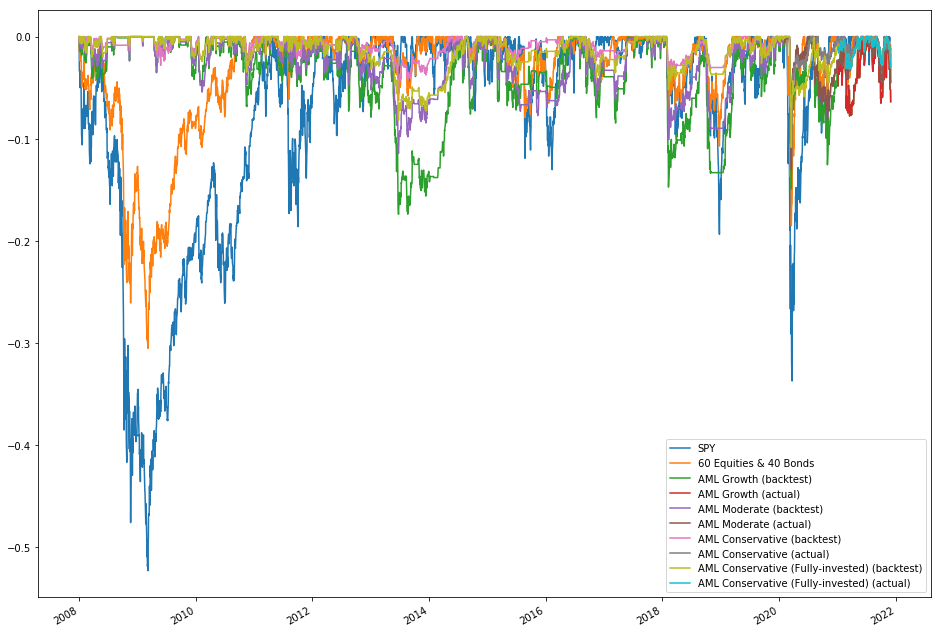

In [17]:
drawdown.plot(figsize=(16, 12))

### lookback annualized metrics

In [18]:
lookback_period = ['INCEPTION']
metrics = pd.DataFrame()
for p in lookback_period:
#     print("===========================================")
    sub_metrics = lookback_metrics_annul(deck_daily_return, p, period_date)
    sub_metrics.index = ["{} daily".format(idx) for idx in sub_metrics.index]
    metrics = pd.concat([metrics, sub_metrics])

    sub_metrics = lookback_metrics_annul_monthly(monthly_return, p, period_date)
    sub_metrics.index = ["{} monthly".format(idx) for idx in sub_metrics.index]
    metrics = pd.concat([metrics, sub_metrics])
metrics

lookback_period:  INCEPTION  sub_df[0]:  2008-01-02 00:00:00  sub_df[-1]:  2021-11-30 00:00:00
lookback_period:  INCEPTION  sub_df[0]:  (2008, 1)  sub_df[-1]:  (2021, 11)


,SPY,60 Equities & 40 Bonds,AML Growth,AML Moderate,AML Conservative,AML Conservative (Fully-invested)
INCEPTION RETURN daily,0.106833,0.097496,0.136856,0.0988093,0.0396799,0.0569428
INCEPTION Volatility daily,0.204946,0.107778,0.11277,0.079604,0.0356386,0.0488572
INCEPTION SHARPE RATIO daily,0.59796,0.917247,1.19413,1.22372,1.10978,1.15809
INCEPTION Max-DD daily,-0.522951,-0.305187,-0.173951,-0.130363,-0.0748305,-0.108379
INCEPTION STD daily,0.0129104,0.00678938,0.00710386,0.00501458,0.00224502,0.00307772
INCEPTION Total Return daily,3.10158,2.6458,4.95073,2.70694,0.71785,1.15988
INCEPTION worst return daily,-0.109424,-0.0531484,-0.0428703,-0.0355664,-0.017744,-0.0279479
INCEPTION RETURN monthly,0.106737,0.0974086,0.136731,0.0987208,0.0396453,0.0568927
INCEPTION Volatility monthly,0.156534,0.0937397,0.117167,0.0818222,0.0344258,0.0451651
INCEPTION SHARPE RATIO monthly,0.729511,1.04249,1.15751,1.1955,1.14822,1.25032


## real trade metrics

In [19]:
real_daily_return = deck_daily_return.loc[ib_df.index, :]

real_cum_retrun = pd.DataFrame()
real_drawdown = pd.DataFrame()
real_metrics = pd.DataFrame()
real_monthly_return = pd.DataFrame()
for col in real_daily_return.columns:
    # cumulative returns
    cum_return_client = empy.cum_returns(real_daily_return[col].dropna())
    real_cum_retrun[col] = cum_return_client
    
    # daily drawdown
    drawdown_client = drawdown_from_return(real_daily_return[col].dropna().fillna(0))
    real_drawdown[col] = drawdown_client
    
    real_monthly_return[col] = empy.aggregate_returns(
        real_daily_return[col].dropna(), convert_to='monthly')

c:\users\ho sumwai\appdata\local\programs\python\python36-64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
c:\users\ho sumwai\appdata\local\programs\python\python36-64\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [20]:
base = '60 Equities & 40 Bonds'

real_cum_retrun = pd.DataFrame()
real_drawdown = pd.DataFrame()
real_metrics = pd.DataFrame()
real_monthly_return = pd.DataFrame()

real_daily_return = deck_daily_return.loc[ib_df.index, :]
bm = real_daily_return[base]
for col in real_daily_return.columns:
    if col.startswith("AML"):
        
        ib_part = ib_df[col].dropna()
        tmp_ib_part = ib_part[ib_part != 0] 
        first_ib_date = tmp_ib_part.index[0]
        bm_part = bm[bm.index < first_ib_date]
        join_ib = ib_part[ib_part.index >= first_ib_date]
        joined_part = pd.concat([bm_part, join_ib])
        real_daily_return[col] = joined_part
        
        cum_return_client = empy.cum_returns(real_daily_return[col].fillna(0))
        cum_return_client = cum_return_client[cum_return_client.index >= first_ib_date]
#         cum_return_client.name = col
#         real_cum_retrun = pd.concat([real_cum_retrun, cum_return_client], axis=1)
        
        drawdown_client = drawdown_from_return(real_daily_return[col].fillna(0))
        drawdown_client = drawdown_client[drawdown_client.index >= first_ib_date]
#         drawdown_client.name = col
#         real_drawdown = pd.concat([real_drawdown, drawdown_client], axis=1)
        
        real_monthly_return[col] = empy.aggregate_returns(
            ib_part.fillna(0), convert_to='monthly')
    else:
        real_monthly_return[col] = empy.aggregate_returns(
            real_daily_return[col].fillna(0), convert_to='monthly')
    
        cum_return_client = empy.cum_returns(real_daily_return[col].fillna(0))
        drawdown_client = drawdown_from_return(real_daily_return[col].fillna(0))
    real_cum_retrun[col] = cum_return_client
    real_drawdown[col] = drawdown_client

c:\users\ho sumwai\appdata\local\programs\python\python36-64\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


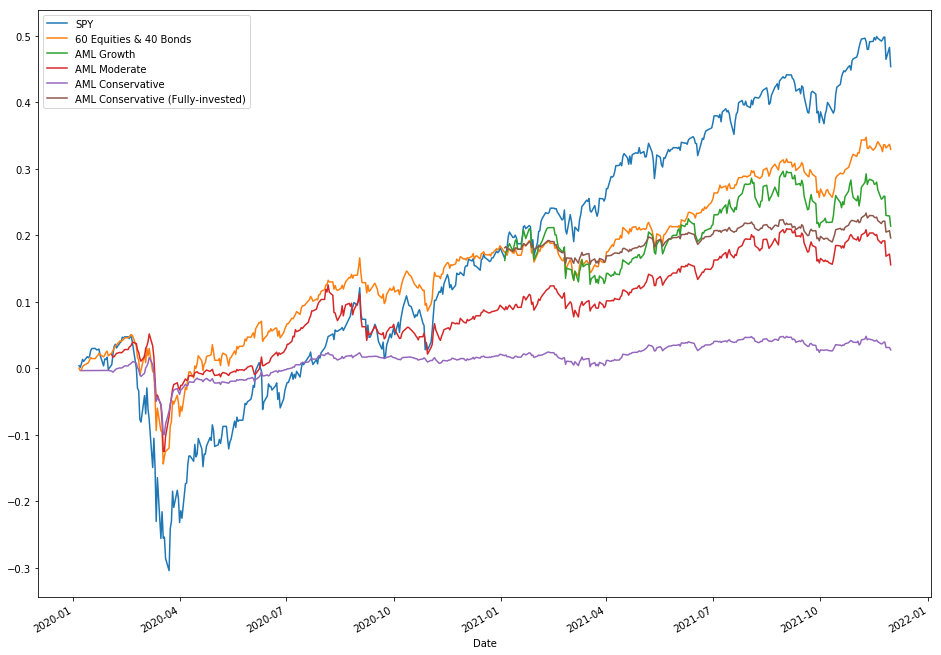

In [21]:
real_cum_retrun.plot(figsize=(16, 12))

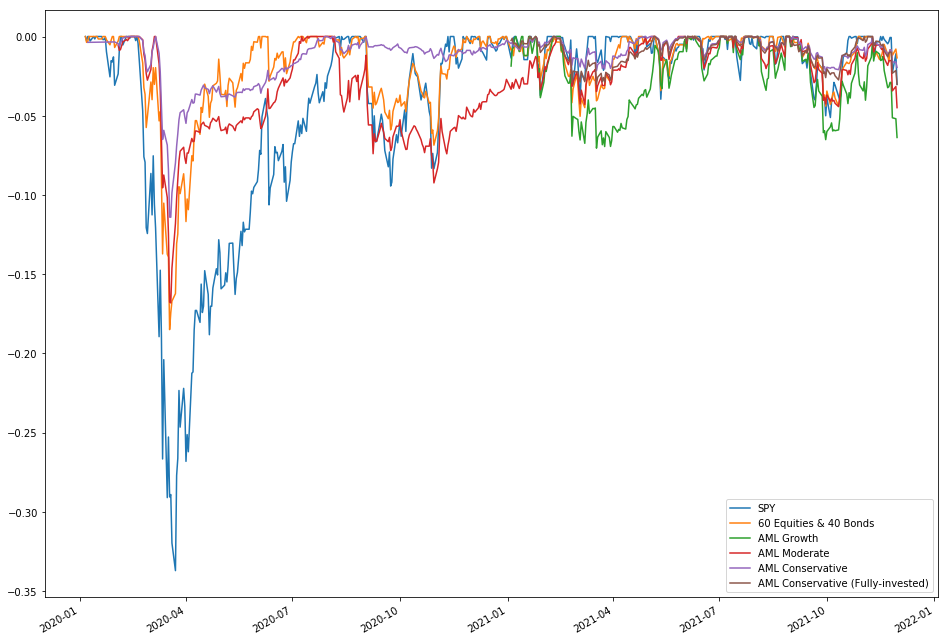

In [22]:
real_drawdown.plot(figsize=(16, 12))

### real report

In [23]:
ib_df = ib_df[clients]
real_daily_return = ib_df.loc[ib_df.index < datetime.strptime(period_date, '%Y-%m-%d')]

benchmark_return = deck_daily_return[benchmark]
benchmark_return = benchmark_return.loc[real_daily_return.index, :]
real_daily_return = pd.concat([benchmark_return, real_daily_return], axis=1)

lookback_period = ['INCEPTION']
real_metrics = pd.DataFrame()
for p in lookback_period:
#     print("===========================================")
    sub_metrics = lookback_A2ACompare(real_daily_return, p, benchmark, period_date)
    sub_metrics.index = ["{} daily".format(idx) for idx in sub_metrics.index]
    real_metrics = pd.concat([real_metrics, sub_metrics])
    
    sub_metrics = lookback_A2ACompare_monthly(real_monthly_return, p, benchmark, period_date)
    sub_metrics.index = ["{} monthly".format(idx) for idx in sub_metrics.index]
    real_metrics = pd.concat([real_metrics, sub_metrics])
real_metrics

lookback_period:  INCEPTION  sub_df[0]:  2020-12-31 00:00:00  sub_df[-1]:  2021-11-30 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  2020-12-31 00:00:00  sub_df[-1]:  2021-11-30 00:00:00
lookback_period:  INCEPTION  sub_df[0]:  2020-02-03 00:00:00  sub_df[-1]:  2021-11-30 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  2020-02-03 00:00:00  sub_df[-1]:  2021-11-30 00:00:00
lookback_period:  INCEPTION  sub_df[0]:  2020-01-06 00:00:00  sub_df[-1]:  2021-11-30 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  2020-01-06 00:00:00  sub_df[-1]:  2021-11-30 00:00:00
lookback_period:  INCEPTION  sub_df[0]:  2020-12-31 00:00:00  sub_df[-1]:  2021-11-30 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  2020-12-31 00:00:00  sub_df[-1]:  2021-11-30 00:00:00
lookback_period with benchmark:  INCEPTION  sub_df[0]:  (2020, 12)  sub_df[-1]:  (2021, 11)
lookback_period with benchmark:  INCEPTION  sub_df[0]:  (2020, 2)  sub_df[-1]:  (2021, 1

c:\users\ho sumwai\appdata\local\programs\python\python36-64\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


,SPY,60 Equities & 40 Bonds,AML Growth,SPY,60 Equities & 40 Bonds,AML Moderate,SPY,60 Equities & 40 Bonds,AML Conservative,SPY,60 Equities & 40 Bonds,AML Conservative (Fully-invested)
INCEPTION RETURN daily,0.260746,0.138855,0.0271392,0.227671,0.156222,0.0711931,0.216418,0.160724,0.016281,0.260746,0.138855,0.0103119
INCEPTION Volatility daily,0.125623,0.0890943,0.130852,0.261123,0.140361,0.112941,0.256978,0.137905,0.0581562,0.125623,0.0890943,0.0541527
INCEPTION SHARPE RATIO daily,1.90794,1.5042,0.270122,0.917292,1.10494,0.665744,0.892023,1.15034,0.306879,1.90794,1.5042,0.216469
INCEPTION Max-DD daily,-0.0511414,-0.0503554,-0.0704701,-0.337173,-0.185036,-0.168162,-0.337173,-0.185036,-0.114088,-0.0511414,-0.0503554,-0.0301008
INCEPTION STD daily,0.0079135,0.00561241,0.0082429,0.0164492,0.00884189,0.00711459,0.0161881,0.00868719,0.00366349,0.0079135,0.00561241,0.0034113
INCEPTION Total Return daily,0.236636,0.126582,0.0248498,0.456523,0.304895,0.134377,0.453451,0.329077,0.0313058,0.236636,0.126582,0.00944853
INCEPTION worst return daily,-0.0244405,-0.0212323,-0.0398023,-0.109424,-0.0531484,-0.0492225,-0.109424,-0.0531484,-0.0326912,-0.0244405,-0.0212323,-0.0146988
INCEPTION RETURN monthly,0.275969,0.1419,0.0248498,0.227671,0.156222,0.0711931,0.215432,0.160008,0.0162129,0.275969,0.1419,0.00990392
INCEPTION Volatility monthly,0.109642,0.0895671,0.110835,0.201752,0.119675,0.10405,0.197695,0.116999,0.0411146,0.109642,0.0895671,0.0509559
INCEPTION SHARPE RATIO monthly,2.2953,1.53058,0.272718,1.1222,1.27658,0.712147,1.08987,1.33165,0.411103,2.2953,1.53058,0.216831


### save record

In [24]:
period_return_fn = os.path.join(result_fn, 'period_return.xlsx')
with pd.ExcelWriter(period_return_fn) as writer:
    for k, df in period_return_dict.items():
        df.to_excel(writer, sheet_name=k[:30])
        
monthly_sharpe_fn = os.path.join(result_fn, 'monthly_sharpe.xlsx')
with pd.ExcelWriter(monthly_sharpe_fn) as writer:
    for k, df in monthly_sharpe_dict.items():
        df.to_excel(writer, sheet_name=k[:30])

overall_perf_fn = os.path.join(result_fn, 'overall_perf_fn.xlsx')
with pd.ExcelWriter(overall_perf_fn) as writer:
    cum_retrun.to_excel(writer, sheet_name='cum_retrun')
    drawdown.to_excel(writer, sheet_name='drawdown')
    metrics.to_excel(writer, sheet_name='lookback_metrics')

    real_cum_retrun.to_excel(writer, sheet_name='real_cum_retrun')
    real_drawdown.to_excel(writer, sheet_name='real_drawdown')
    real_metrics.to_excel(writer, sheet_name='real_lookback_metrics')